In [25]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import hvplot.pandas
import requests
import json
import scipy.stats as st
from scipy.stats import linregress
from api_keys import geoapify_key

In [2]:
crime_data = Path("Crime_Reports.csv")

# Read in the data. 
crime_data_df = pd.read_csv(crime_data)
crime_data_df.columns

C:\Users\Nomanos\AppData\Local\Temp\ipykernel_15788\179752030.py:4: DtypeWarning: Columns (16,26) have mixed types. Specify dtype option on import or set low_memory=False.
  crime_data_df = pd.read_csv(crime_data)


Index(['Incident Number', 'Highest Offense Description',
       'Highest Offense Code', 'Family Violence', 'Occurred Date Time',
       'Occurred Date', 'Occurred Time', 'Report Date Time', 'Report Date',
       'Report Time', 'Location Type', 'Address', 'Zip Code',
       'Council District', 'APD Sector', 'APD District', 'PRA', 'Census Tract',
       'Clearance Status', 'Clearance Date', 'UCR Category',
       'Category Description', 'X-coordinate', 'Y-coordinate', 'Latitude',
       'Longitude', 'Location'],
      dtype='object')

In [3]:
# Keep only certain columns
reduced_crime_df = crime_data_df.loc[:,['Highest Offense Description', 'Highest Offense Code','Occurred Date','Occurred Time',
                                        'Location Type','Address','Latitude','Longitude','Zip Code','APD Sector','APD District','Clearance Status']]
reduced_crime_df

# Filter lat/long just for Austin area
clean_crime_loc_df = reduced_crime_df.loc[((crime_data_df["Latitude"] <= 31) & (crime_data_df["Latitude"] >= 30)) & 
                                       ((crime_data_df["Longitude"] <= -97.5) & (crime_data_df["Longitude"] >= -98)), :]
clean_crime_loc_df

,Highest Offense Description,Highest Offense Code,Occurred Date,Occurred Time,Location Type,Address,Latitude,Longitude,Zip Code,APD Sector,APD District,Clearance Status
36274,BURGLARY OF VEHICLE,601,12/01/2022,1130.0,RESIDENCE / HOME,1921 WILLOW CREEK DR,30.232680,-97.727425,78741.0,HE,2,N
36275,BURGLARY OF SHED/DETACHED GARAGE/STORAGE UNIT,504,11/07/2022,2000.0,PARKING /DROP LOT/ GARAGE,4113 AVENUE F,30.304627,-97.729489,78751.0,BA,5,NaN
36277,THEFT OF METAL,619,12/01/2022,2327.0,COMMERCIAL / OFFICE BUILDING,300 W 6TH ST,30.269110,-97.745659,78701.0,GE,1,N
36278,DOC UNREASONABLE NOISE,2405,12/03/2022,500.0,RESIDENCE / HOME,11704 N LAMAR BLVD,30.386647,-97.684531,78758.0,ED,4,N
36279,THEFT,600,10/29/2022,2300.0,RESIDENCE / HOME,708 E 6TH ST,30.266186,-97.735585,78701.0,GE,2,N
...,...,...,...,...,...,...,...,...,...,...,...,...
2371188,DEBIT CARD ABUSE,1108,09/24/2020,1200.0,OTHER / UNKNOWN,3800 DROSSETT DR,30.211876,-97.731707,78744.0,FR,6,N
2371189,BURGLARY OF VEHICLE,601,03/19/2010,1900.0,FIELD / WOODS,2201 ANDREW ZILKER RD,30.265757,-97.770554,78746.0,DA,1,N
2371190,PROTECTIVE ORDER,3829,12/16/2008,1556.0,RESIDENCE / HOME,1106 WEATHERS LN,30.239131,-97.770694,78704.0,DA,2,NaN
2371191,VIOL CITY ORDINANCE - OTHER,3299,06/06/2010,31.0,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,675 E RUNDBERG LN,30.358489,-97.688952,78753.0,ED,1,C


In [4]:
# Add empty columen for Occurred Year
clean_crime_loc_df.insert(3, "Occurred Date - Year", "")
clean_crime_loc_df

,Highest Offense Description,Highest Offense Code,Occurred Date,Occurred Date - Year,Occurred Time,Location Type,Address,Latitude,Longitude,Zip Code,APD Sector,APD District,Clearance Status
36274,BURGLARY OF VEHICLE,601,12/01/2022,,1130.0,RESIDENCE / HOME,1921 WILLOW CREEK DR,30.232680,-97.727425,78741.0,HE,2,N
36275,BURGLARY OF SHED/DETACHED GARAGE/STORAGE UNIT,504,11/07/2022,,2000.0,PARKING /DROP LOT/ GARAGE,4113 AVENUE F,30.304627,-97.729489,78751.0,BA,5,NaN
36277,THEFT OF METAL,619,12/01/2022,,2327.0,COMMERCIAL / OFFICE BUILDING,300 W 6TH ST,30.269110,-97.745659,78701.0,GE,1,N
36278,DOC UNREASONABLE NOISE,2405,12/03/2022,,500.0,RESIDENCE / HOME,11704 N LAMAR BLVD,30.386647,-97.684531,78758.0,ED,4,N
36279,THEFT,600,10/29/2022,,2300.0,RESIDENCE / HOME,708 E 6TH ST,30.266186,-97.735585,78701.0,GE,2,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371188,DEBIT CARD ABUSE,1108,09/24/2020,,1200.0,OTHER / UNKNOWN,3800 DROSSETT DR,30.211876,-97.731707,78744.0,FR,6,N
2371189,BURGLARY OF VEHICLE,601,03/19/2010,,1900.0,FIELD / WOODS,2201 ANDREW ZILKER RD,30.265757,-97.770554,78746.0,DA,1,N
2371190,PROTECTIVE ORDER,3829,12/16/2008,,1556.0,RESIDENCE / HOME,1106 WEATHERS LN,30.239131,-97.770694,78704.0,DA,2,NaN
2371191,VIOL CITY ORDINANCE - OTHER,3299,06/06/2010,,31.0,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,675 E RUNDBERG LN,30.358489,-97.688952,78753.0,ED,1,C


In [5]:
# Split year from occured Date
for index, row in clean_crime_loc_df.iterrows():
    #Get occured date time
    try:
        clean_crime_loc_df.loc[index, "Occurred Date - Year"] = clean_crime_loc_df.loc[index, "Occurred Date"][-4:]
    except:
        clean_crime_loc_df.loc[index, "Occurred Date - Year"] = "NaN"

clean_crime_loc_df



,Highest Offense Description,Highest Offense Code,Occurred Date,Occurred Date - Year,Occurred Time,Location Type,Address,Latitude,Longitude,Zip Code,APD Sector,APD District,Clearance Status
36274,BURGLARY OF VEHICLE,601,12/01/2022,2022,1130.0,RESIDENCE / HOME,1921 WILLOW CREEK DR,30.232680,-97.727425,78741.0,HE,2,N
36275,BURGLARY OF SHED/DETACHED GARAGE/STORAGE UNIT,504,11/07/2022,2022,2000.0,PARKING /DROP LOT/ GARAGE,4113 AVENUE F,30.304627,-97.729489,78751.0,BA,5,NaN
36277,THEFT OF METAL,619,12/01/2022,2022,2327.0,COMMERCIAL / OFFICE BUILDING,300 W 6TH ST,30.269110,-97.745659,78701.0,GE,1,N
36278,DOC UNREASONABLE NOISE,2405,12/03/2022,2022,500.0,RESIDENCE / HOME,11704 N LAMAR BLVD,30.386647,-97.684531,78758.0,ED,4,N
36279,THEFT,600,10/29/2022,2022,2300.0,RESIDENCE / HOME,708 E 6TH ST,30.266186,-97.735585,78701.0,GE,2,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371188,DEBIT CARD ABUSE,1108,09/24/2020,2020,1200.0,OTHER / UNKNOWN,3800 DROSSETT DR,30.211876,-97.731707,78744.0,FR,6,N
2371189,BURGLARY OF VEHICLE,601,03/19/2010,2010,1900.0,FIELD / WOODS,2201 ANDREW ZILKER RD,30.265757,-97.770554,78746.0,DA,1,N
2371190,PROTECTIVE ORDER,3829,12/16/2008,2008,1556.0,RESIDENCE / HOME,1106 WEATHERS LN,30.239131,-97.770694,78704.0,DA,2,NaN
2371191,VIOL CITY ORDINANCE - OTHER,3299,06/06/2010,2010,31.0,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,675 E RUNDBERG LN,30.358489,-97.688952,78753.0,ED,1,C


In [6]:
# Drop NAs from data, export cleaned data to csv
clean_crime_df = clean_crime_loc_df.dropna()

clean_crime_df.to_csv("Output/crime_report_cleaned.csv", index=False, header=True)

In [7]:
# Get data for alcohol and marajuana related reports

df_csv_alcohol = clean_crime_df.loc[(clean_crime_df["Highest Offense Code"] == 2100) |
                              (clean_crime_df["Highest Offense Code"] == 2102) |
                              (clean_crime_df["Highest Offense Code"] == 2111) |
                              (clean_crime_df["Highest Offense Code"] == 2103) |
                              (clean_crime_df["Highest Offense Code"] == 2108) |
                              (clean_crime_df["Highest Offense Code"] == 3211) |
                              (clean_crime_df["Highest Offense Code"] == 2209) |
                              (clean_crime_df["Highest Offense Code"] == 2200) |
                              (clean_crime_df["Highest Offense Code"] == 2109) |
                              (clean_crime_df["Highest Offense Code"] == 2206) |
                              (clean_crime_df["Highest Offense Code"] == 2208) |
                              (clean_crime_df["Highest Offense Code"] == 2107) |
                              (clean_crime_df["Highest Offense Code"] == 2106) |
                              (clean_crime_df["Highest Offense Code"] == 2105) |
                              (clean_crime_df["Highest Offense Code"] == 108) |
                              (clean_crime_df["Highest Offense Code"] == 2110) |
                              (clean_crime_df["Highest Offense Code"] == 2202) |
                              (clean_crime_df["Highest Offense Code"] == 2203) |
                              (clean_crime_df["Highest Offense Code"] == 2104),:]

df_csv_mj = clean_crime_df.loc[(clean_crime_df["Highest Offense Code"] == 1803) |
                              (clean_crime_df["Highest Offense Code"] == 1825) |
                              (clean_crime_df["Highest Offense Code"] == 1807) |
                              (clean_crime_df["Highest Offense Code"] == 1826) |
                              (clean_crime_df["Highest Offense Code"] == 1827) |
                              (clean_crime_df["Highest Offense Code"] == 1827),:]

# Print results:
print(f"We have {len(df_csv_alcohol)} alcohol crimes and "\
      f"{len(df_csv_mj)} mj crimes in Austin.")

We have 94193 alcohol crimes and 31308 mj crimes in Austin.


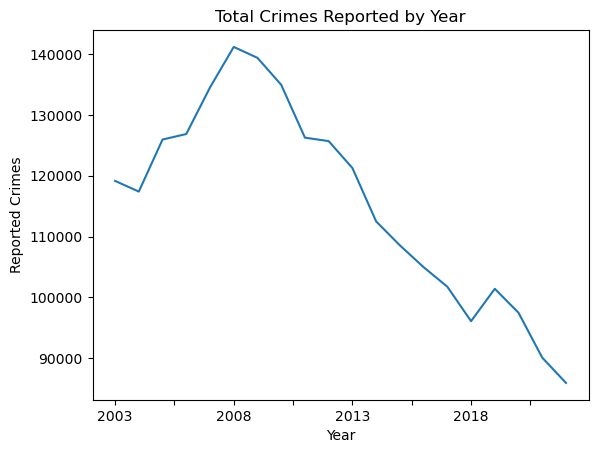

In [8]:
# Show graph of number of crimes by year

crime_counts_by_year = clean_crime_loc_df["Occurred Date - Year"].value_counts().sort_index()
crime_counts_by_year = crime_counts_by_year.drop(index="2023")
xticklabels = crime_counts_by_year.index
crime_by_year = crime_counts_by_year.plot(kind="line",title="Total Crimes Reported by Year", xlabel="Year", 
                                          ylabel="Reported Crimes")


<AxesSubplot:>

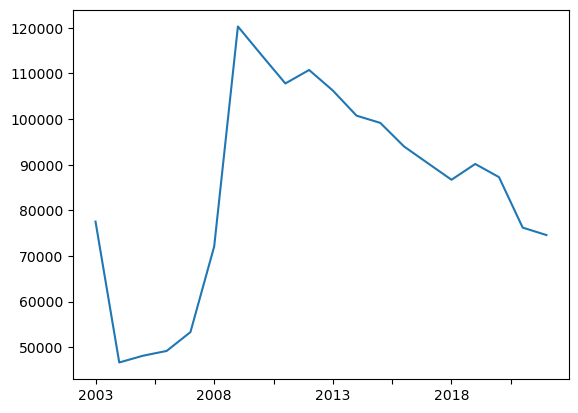

In [9]:
# Show graph of number of crimes by year

crime_counts_by_year = clean_crime_df["Occurred Date - Year"].value_counts().sort_index()
crime_counts_by_year = crime_counts_by_year.drop(index="2023")
crime_counts_by_year.plot(kind="line")

<AxesSubplot:title={'center':'Total Alcohol Crimes Reported by Year'}, xlabel='Year', ylabel='Reported Crimes'>

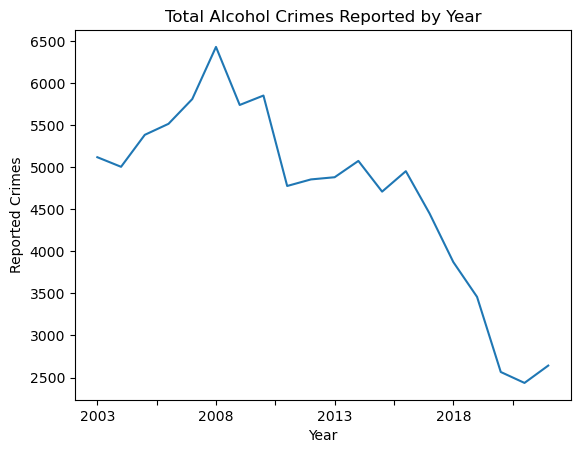

In [10]:
# Show graph of number of crimes by year

alc_crime_counts_by_year = df_csv_alcohol["Occurred Date - Year"].value_counts().sort_index()

alc_crime_counts_by_year = alc_crime_counts_by_year.drop(index="2023")
alc_crime_counts_by_year.plot(kind="line",title="Total Alcohol Crimes Reported by Year", xlabel="Year", 
                                          ylabel="Reported Crimes")

<AxesSubplot:title={'center':'Total Marijuana Reported by Year'}, xlabel='Year', ylabel='Reported Crimes'>

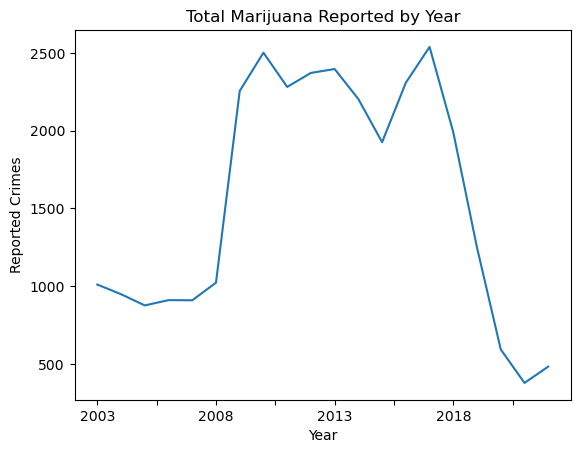

In [11]:
# Show graph of number of crimes by year

mj_crime_counts_by_year = df_csv_mj["Occurred Date - Year"].value_counts().sort_index()
mj_crime_counts_by_year = mj_crime_counts_by_year.drop(index="2023")
mj_crime_counts_by_year.plot(kind="line",title="Total Marijuana Reported by Year", xlabel="Year", 
                                          ylabel="Reported Crimes")

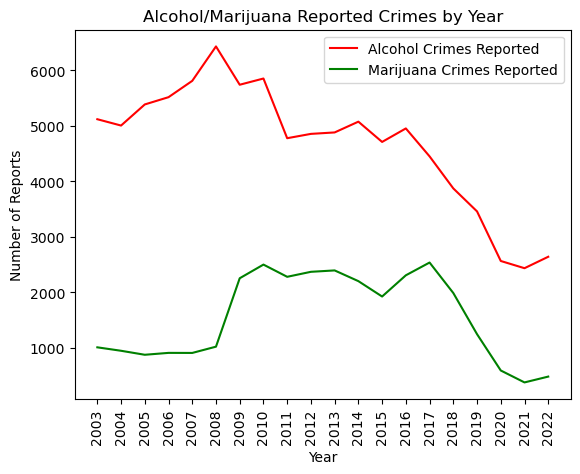

In [12]:
#tot_crime, = plt.plot(crime_counts_by_year.keys(), crime_counts_by_year, color='blue', label="Total Crimes Reported")
alc_crime, = plt.plot(alc_crime_counts_by_year.keys(), alc_crime_counts_by_year, color='red', label="Alcohol Crimes Reported")
mj_crime, = plt.plot(mj_crime_counts_by_year.keys(), mj_crime_counts_by_year, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime, mj_crime], loc="upper right")
plt.title("Alcohol/Marijuana Reported Crimes by Year")
plt.ylabel("Number of Reports")
plt.xlabel("Year")
plt.xkcd(scale=1, length=100, randomness=2)

plt.show()

In [13]:
df_csv_mj['Month']=pd.to_datetime(df_csv_mj['Occurred Date']).dt.strftime('%m')
#df_mj.columns

df_csv_alcohol['Month']=pd.to_datetime(df_csv_alcohol['Occurred Date']).dt.strftime('%m')
df_csv_alcohol.columns

C:\Users\Nomanos\AppData\Local\Temp\ipykernel_15788\408270823.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv_mj['Month']=pd.to_datetime(df_csv_mj['Occurred Date']).dt.strftime('%m')
C:\Users\Nomanos\AppData\Local\Temp\ipykernel_15788\408270823.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv_alcohol['Month']=pd.to_datetime(df_csv_alcohol['Occurred Date']).dt.strftime('%m')


Index(['Highest Offense Description', 'Highest Offense Code', 'Occurred Date',
       'Occurred Date - Year', 'Occurred Time', 'Location Type', 'Address',
       'Latitude', 'Longitude', 'Zip Code', 'APD Sector', 'APD District',
       'Clearance Status', 'Month'],
      dtype='object')

In [14]:
#grouping alcohol reported crimes by month and year
OHyear_2017=df_csv_alcohol.loc[(df_csv_alcohol['Occurred Date - Year'] == '2017')]
month_oh17=OHyear_2017.groupby(["Month"])['Highest Offense Description'].count().sort_index()

OHyear_2018=df_csv_alcohol.loc[(df_csv_alcohol['Occurred Date - Year'] == '2018')]
month_oh18=OHyear_2018.groupby(["Month"])['Highest Offense Description'].count().sort_index()

OHyear_2019=df_csv_alcohol.loc[(df_csv_alcohol['Occurred Date - Year'] == '2019')]
month_oh19=OHyear_2019.groupby(["Month"])['Highest Offense Description'].count().sort_index()

OHyear_2020=df_csv_alcohol.loc[(df_csv_alcohol['Occurred Date - Year'] == '2020')]
month_oh20=OHyear_2020.groupby(["Month"])['Highest Offense Description'].count().sort_index()

OHyear_2021=df_csv_alcohol.loc[(df_csv_alcohol['Occurred Date - Year'] == '2021')]
month_oh21=OHyear_2021.groupby(["Month"])['Highest Offense Description'].count().sort_index()

OHyear_2022=df_csv_alcohol.loc[(df_csv_alcohol['Occurred Date - Year'] == '2022')]
month_oh22=OHyear_2022.groupby(["Month"])['Highest Offense Description'].count().sort_index()

In [15]:
#grouping marijuana reported crimes by month and year
year_2017=df_csv_mj.loc[(df_csv_mj['Occurred Date - Year'] == '2017')]
month_mj17=year_2017.groupby(["Month"])['Highest Offense Description'].count().sort_index()

year_2018=df_csv_mj.loc[(df_csv_mj['Occurred Date - Year'] == '2018')]
month_mj18=year_2018.groupby(["Month"])['Highest Offense Description'].count().sort_index()

year_2019=df_csv_mj.loc[(df_csv_mj['Occurred Date - Year'] == '2019')]
month_mj19=year_2019.groupby(["Month"])['Highest Offense Description'].count().sort_index()

year_2020=df_csv_mj.loc[(df_csv_mj['Occurred Date - Year'] == '2020')]
month_mj20=year_2020.groupby(["Month"])['Highest Offense Description'].count().sort_index()

year_2021=df_csv_mj.loc[(df_csv_mj['Occurred Date - Year'] == '2021')]
month_mj21=year_2021.groupby(["Month"])['Highest Offense Description'].count().sort_index()

year_2022=df_csv_mj.loc[(df_csv_mj['Occurred Date - Year'] == '2022')]
month_mj22=year_2022.groupby(["Month"])['Highest Offense Description'].count().sort_index()



Text(0.5, 0, 'Months')

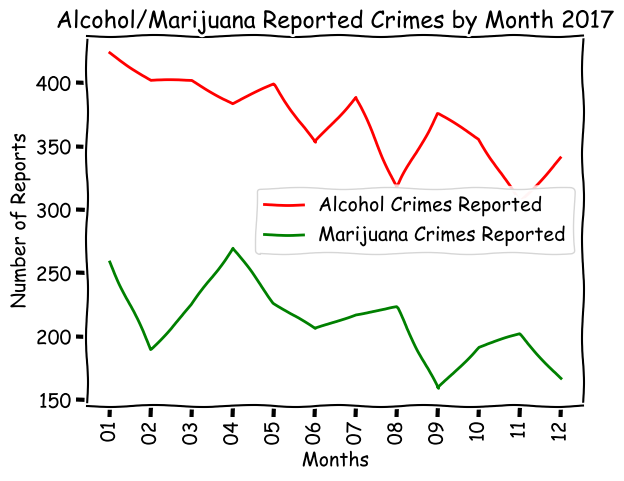

In [16]:
#monthly plot alcohol and mj 2017
alc_crime17, = plt.plot(month_oh17.keys(), month_oh17, color='red', label="Alcohol Crimes Reported")
mj_crime17, = plt.plot(month_mj17.keys(), month_mj17, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime17, mj_crime17], loc="center right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2017")
plt.ylabel("Number of Reports")
plt.xlabel("Months")

Text(0.5, 0, 'Months')

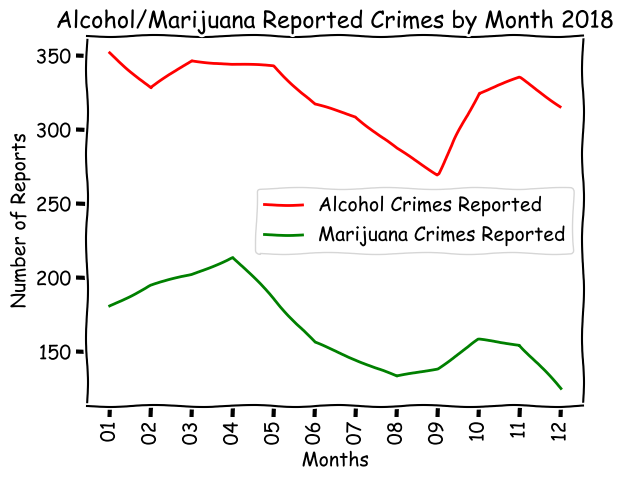

In [17]:
#monthly plot alcohol and mj 2018
alc_crime18, = plt.plot(month_oh18.keys(), month_oh18, color='red', label="Alcohol Crimes Reported")
mj_crime18, = plt.plot(month_mj18.keys(), month_mj18, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime18, mj_crime18], loc="center right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2018")
plt.ylabel("Number of Reports")
plt.xlabel("Months")

Text(0.5, 0, 'Months')

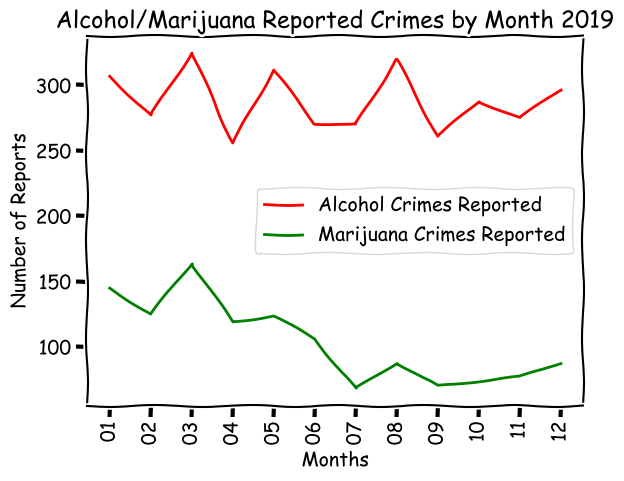

In [18]:
#monthly plot alcohol and mj 2019
alc_crime19, = plt.plot(month_oh19.keys(), month_oh19, color='red', label="Alcohol Crimes Reported")
mj_crime19, = plt.plot(month_mj19.keys(), month_mj19, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime19, mj_crime19], loc="center right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2019")
plt.ylabel("Number of Reports")
plt.xlabel("Months")

Text(0.5, 0, 'Months')

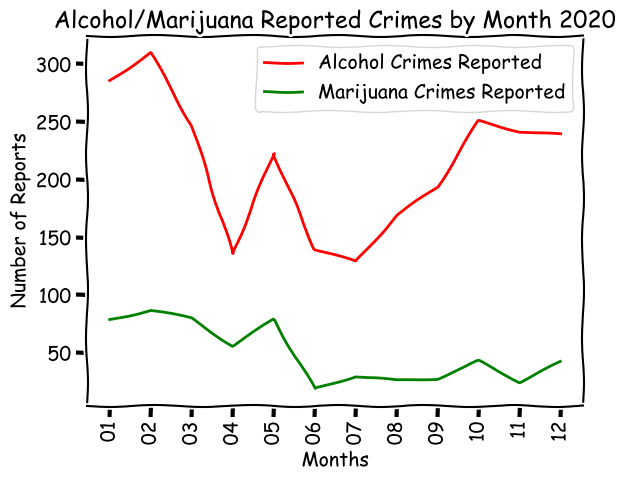

In [19]:
#monthly plot alcohol and mj 2020
alc_crime20, = plt.plot(month_oh20.keys(), month_oh20, color='red', label="Alcohol Crimes Reported")
mj_crime20, = plt.plot(month_mj20.keys(), month_mj20, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime20, mj_crime20], loc="upper right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2020")
plt.ylabel("Number of Reports")
plt.xlabel("Months")

Text(0.5, 0, 'Months')

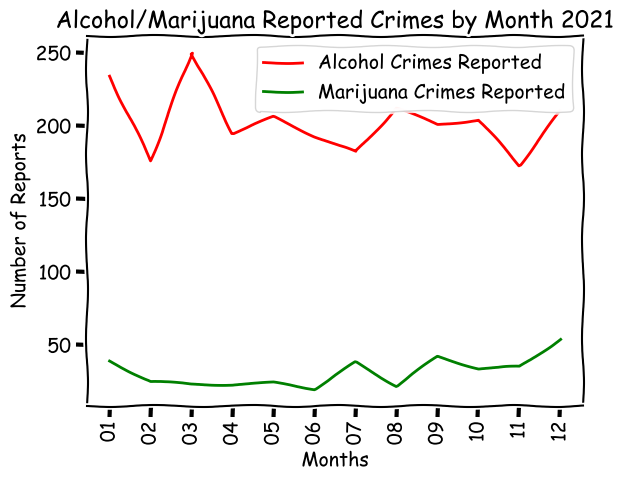

In [20]:
#monthly plot alcohol and mj 2021
alc_crime21, = plt.plot(month_oh21.keys(), month_oh21, color='red', label="Alcohol Crimes Reported")
mj_crime21, = plt.plot(month_mj21.keys(), month_mj21, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime21, mj_crime21], loc="upper right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2021")
plt.ylabel("Number of Reports")
plt.xlabel("Months")

Text(0.5, 0, 'Months')

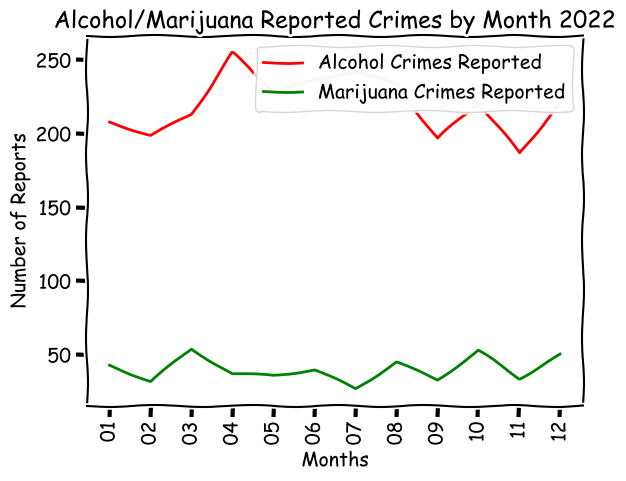

In [21]:
#monthly plot alcohol and mj 2022
alc_crime22, = plt.plot(month_oh22.keys(), month_oh22, color='red', label="Alcohol Crimes Reported")
mj_crime22, = plt.plot(month_mj22.keys(), month_mj22, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime22, mj_crime22], loc="upper right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2022")
plt.ylabel("Number of Reports")
plt.xlabel("Months")

In [22]:
#Find correlation between MJ reported crimes and alcohol from 2003 to 2023
#create new df
OH_crime_count_zc=df_csv_alcohol["Zip Code"].value_counts().sort_index()
mj_crime_count_zc=df_csv_mj["Zip Code"].value_counts().sort_index()
mj_oh=pd.DataFrame({"Marihuana":mj_crime_count_zc,"Alcohol":OH_crime_count_zc})
mj_oh.fillna(0, inplace=True)


In [23]:
mj_oh.describe()

,Marihuana,Alcohol
count,58.000000,58.000000
mean,539.793103,1624.017241
std,909.260366,2586.045776
min,0.000000,1.000000
25%,8.500000,41.500000
50%,140.500000,502.500000
75%,562.750000,1785.250000
max,3682.000000,12011.000000


The r-value is: 0.8663940682520423


<function matplotlib.pyplot.show(close=None, block=None)>

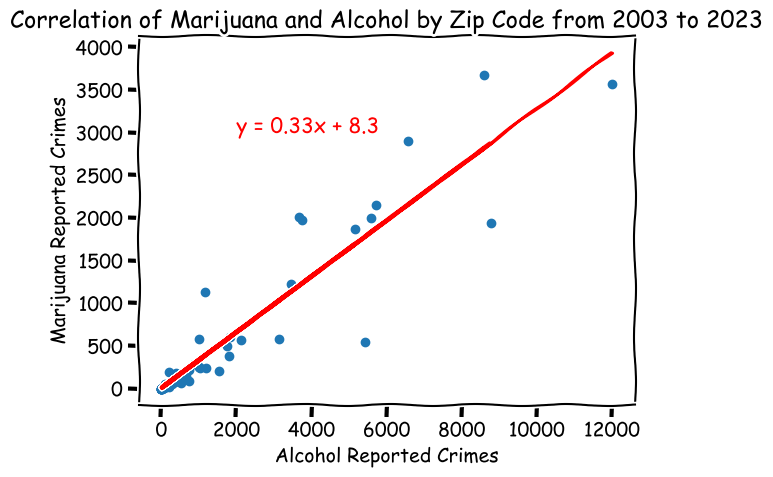

In [24]:
#plot correlation
y=mj_oh["Marihuana"].astype('float')
x=mj_oh["Alcohol"].astype('float')

#linear regression
(slope,intercept,rvalue,pvalue,stderr)= linregress(x,y)
regress_values= x * slope + intercept
line_eq="y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

#plot
plt.scatter(x,y)
plt.plot(x,regress_values, "r-")
plt.title("Correlation of Marijuana and Alcohol by Zip Code from 2003 to 2023")
plt.xlabel("Alcohol Reported Crimes")
plt.ylabel("Marijuana Reported Crimes")
plt.annotate(line_eq,(2000,3000),fontsize=15,color="red")
#R value
print(f"The r-value is: {rvalue**2}")
plt.show

In [26]:
#Determine Correlation
y=mj_oh["Marihuana"]
x=mj_oh["Alcohol"]
correlation= st.pearsonr(x,y)
print(f"The correlation between both is {round(correlation[0],2)}")

The correlation between both is 0.93


In [84]:
mj_map = df_csv_mj.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500
)

mj_map


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]

In [85]:
alcohol_map = df_csv_alcohol.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500
)

alcohol_map

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]

In [86]:
# Show graph of number of alcohol crimes by zip

alc_crime_counts_by_zip = df_csv_alcohol["Zip Code"].value_counts().sort_index()
#crime_counts_by_year.sort_index(ascending=True)
alc_crime_counts_by_zip

78610.0        9
78613.0      191
78617.0      396
78626.0        1
78634.0        1
78640.0        1
78641.0        2
78642.0        1
78645.0        1
78652.0       18
78653.0       61
78660.0      364
78664.0       20
78665.0        1
78681.0       27
78701.0    12011
78702.0     6574
78703.0     5427
78704.0     8778
78705.0     2133
78712.0       98
78717.0      510
78719.0      202
78721.0     1162
78722.0      879
78723.0     3676
78724.0      994
78725.0      108
78726.0      296
78727.0     1002
78728.0      191
78729.0      734
78730.0       79
78731.0     1529
78732.0       35
78733.0        5
78734.0        4
78735.0      729
78736.0      111
78737.0       21
78739.0       93
78741.0     8588
78742.0       98
78744.0     3736
78745.0     5591
78746.0     1195
78747.0      495
78748.0     1816
78749.0     1032
78750.0      991
78751.0     1750
78752.0     3449
78753.0     5712
78754.0      543
78756.0      653
78757.0     1797
78758.0     5146
78759.0     3126
Name: Zip Code

In [87]:
zip_alc_df = pd.DataFrame(df_csv_alcohol["Zip Code"].value_counts())
zip_alc_df.insert(1, "Latitude", "")
zip_alc_df.insert(2, "Longitude", "")

len(zip_alc_df)

58

In [88]:
zip_alc_df = zip_alc_df.rename(columns={"Zip Code": "Number of Reports"})
zip_alc_df.insert(3, "Zip Code", "")
zip_alc_df

,Number of Reports,Latitude,Longitude,Zip Code
78701.0,12011,,,
78704.0,8778,,,
78741.0,8588,,,
78702.0,6574,,,
78753.0,5712,,,
78745.0,5591,,,
78703.0,5427,,,
78758.0,5146,,,
78744.0,3736,,,
78723.0,3676,,,


In [89]:
# Set parameters to search for zip long, lat

params = {
    "type":"postcode",
    "apiKey":geoapify_key
}

# Print a message to follow up the hotel search
print("Starting zip search")

for index, row in zip_alc_df.iterrows():
    
    # get Zip Code from the DataFrame, convert from float to object, drop decimal
    ind = str(index)[:-2]
    
    # Set base URL
    base_url = "https://api.geoapify.com/v1/geocode/search?text=" + ind


    # Make and API request using the params dictionaty
    name_address = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = name_address.json()
    #print(json.dumps(name_address, indent=4))
    # break

    try:
        if name_address["features"][0]["properties"]["city"] == 'Austin':

            zip_alc_df.loc[index, "Zip Code"] = ind
    
            try:
                zip_alc_df.loc[index, "Latitude"] = name_address["features"][0]["properties"]["lat"]
                zip_alc_df.loc[index, "Longitude"] = name_address["features"][0]["properties"]["lon"]
            except (KeyError, IndexError):
                print("No Zip " + ind)
        else:
            #print("not in austin")
            zip_alc_df = zip_alc_df.drop(index=index)
    except (KeyError, IndexError):
        #print("Not in Austin")
        zip_alc_df = zip_alc_df.drop(index=index)
       
# Display sample data

zip_alc_df


Starting zip search


,Number of Reports,Latitude,Longitude,Zip Code
78701.0,12011,30.270412,-97.742935,78701
78704.0,8778,30.24443,-97.761613,78704
78741.0,8588,30.231028,-97.720128,78741
78702.0,6574,30.268695,-97.717508,78702
78753.0,5712,30.377821,-97.677421,78753
78745.0,5591,30.208502,-97.792182,78745
78703.0,5427,30.289265,-97.765464,78703
78758.0,5146,30.381173,-97.707097,78758
78744.0,3736,30.184489,-97.740816,78744
78723.0,3676,30.301331,-97.691979,78723


In [113]:
#len(zip_alc_df)
zip_alc_df = zip_alc_df.sort_index()
zip_alc_df

,Number of Reports,Latitude,Longitude,Zip Code
78617.0,396,30.160732,-97.609364,78617
78701.0,12011,30.270412,-97.742935,78701
78702.0,6574,30.268695,-97.717508,78702
78703.0,5427,30.289265,-97.765464,78703
78704.0,8778,30.24443,-97.761613,78704
78705.0,2133,30.292294,-97.739032,78705
78712.0,98,30.285674,-97.735385,78712
78717.0,510,30.492725,-97.770826,78717
78721.0,1162,30.272728,-97.684916,78721
78722.0,879,30.287225,-97.718214,78722


In [133]:
try:
    #zip_map = zip_alc_df.hvplot.labels(x="Latitude", y="Longitude", title="Alcohol Reported Crimes by Zip Code")
    zip_map = zip_alc_df.hvplot.points(
        "Longitude",
        "Latitude",
        geo = True,
        tiles = "OSM",
        size = "Number of Reports",
        color="Zip Code",
        frame_width = 700,
        frame_height = 500
    ).opts(title="Alcohol Reported Crimes by Zip Code")
except:
    print("nope")

zip_map

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Zip Code,Number of Reports)

In [105]:
zip_mj_df = pd.DataFrame(df_csv_mj["Zip Code"].value_counts())
zip_mj_df.insert(1, "Latitude", "")
zip_mj_df.insert(2, "Longitude", "")

len(zip_mj_df)

51

In [106]:
zip_mj_df = zip_mj_df.rename(columns={"Zip Code": "Number of Reports"})
zip_mj_df.insert(3, "Zip Code", "")
zip_mj_df

,Number of Reports,Latitude,Longitude,Zip Code
78741.0,3682,,,
78701.0,3572,,,
78702.0,2902,,,
78753.0,2156,,,
78723.0,2017,,,
78745.0,1998,,,
78744.0,1973,,,
78704.0,1938,,,
78758.0,1870,,,
78752.0,1222,,,


In [107]:
# Set parameters to search for zip long, lat

params = {
    "type":"postcode",
    "apiKey":geoapify_key
}

# Print a message to follow up the hotel search
print("Starting zip search")

for index, row in zip_mj_df.iterrows():
    
    # get Zip Code from the DataFrame, convert from float to object, drop decimal
    ind = str(index)[:-2]
    
    # Set base URL
    base_url = "https://api.geoapify.com/v1/geocode/search?text=" + ind


    # Make and API request using the params dictionaty
    name_address = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = name_address.json()
    #print(json.dumps(name_address, indent=4))
    # break

    try:
        if name_address["features"][0]["properties"]["city"] == 'Austin':

            zip_mj_df.loc[index, "Zip Code"] = ind
    
            try:
                zip_mj_df.loc[index, "Latitude"] = name_address["features"][0]["properties"]["lat"]
                zip_mj_df.loc[index, "Longitude"] = name_address["features"][0]["properties"]["lon"]
            except (KeyError, IndexError):
                print("No Zip " + ind)
        else:
            #print("not in austin")
            zip_mj_df = zip_mj_df.drop(index=index)
    except (KeyError, IndexError):
        #print("Not in Austin")
        zip_mj_df = zip_mj_df.drop(index=index)
       
# Display sample data

zip_mj_df

Starting zip search


,Number of Reports,Latitude,Longitude,Zip Code
78741.0,3682,30.231028,-97.720128,78741
78701.0,3572,30.270412,-97.742935,78701
78702.0,2902,30.268695,-97.717508,78702
78753.0,2156,30.377821,-97.677421,78753
78723.0,2017,30.301331,-97.691979,78723
78745.0,1998,30.208502,-97.792182,78745
78744.0,1973,30.184489,-97.740816,78744
78704.0,1938,30.24443,-97.761613,78704
78758.0,1870,30.381173,-97.707097,78758
78752.0,1222,30.326247,-97.701883,78752


In [112]:
zip_mj_df = zip_mj_df.sort_index()
zip_mj_df

,Number of Reports,Latitude,Longitude,Zip Code
78617.0,182,30.160732,-97.609364,78617
78701.0,3572,30.270412,-97.742935,78701
78702.0,2902,30.268695,-97.717508,78702
78703.0,550,30.289265,-97.765464,78703
78704.0,1938,30.24443,-97.761613,78704
78705.0,567,30.292294,-97.739032,78705
78712.0,32,30.285674,-97.735385,78712
78717.0,66,30.492725,-97.770826,78717
78721.0,1138,30.272728,-97.684916,78721
78722.0,292,30.287225,-97.718214,78722


In [150]:
try:
    zip_mj_map = zip_mj_df.hvplot.points(
        "Longitude",
        "Latitude",
        geo = True,
        tiles = "OSM",
        size = "Number of Reports",
        color="Zip Code",
        frame_width = 700,
        frame_height = 500
    ).opts(title="Marijuana Reported Crimes by Zip Code")
except:
    print("nope")

zip_mj_map

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Zip Code,Number of Reports)